- Taufik Hidayah
- MC327D5Y0261
- alhidayahtaufik010@gmail.com

# Library

In [ ]:
import os
import re
import sys
from pathlib import Path

import nltk
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import joblib

import warnings

warnings.filterwarnings("ignore")

# custom package imports
from src import (
    cleaningText,
    tokenizingText,
    replace_slang_word,
    filteringText,
    toSentence,
    train_and_evaluate_models,
    scrape_play_store_reviews,
    save_model,
)

In [2]:
project_root = Path(os.getcwd())

RAW_DATA_PATH = project_root / "data" / "raw"
PROCESSED_DATA_PATH = project_root / "data" / "processed"
DICTIONARIES_PATH = project_root / "data" / "dictionaries"
REPORT_PATH = project_root / "reports"
MODELS_PATH = project_root / "models"

# Data Collection

In [3]:
## use this to scrape the play store reviews
# app_id = "app.bpjs.mobile"

# scrape_play_store_reviews(app_id=app_id, jumlah_ulasan=200000, output_dir=RAW_DATA_PATH)

# Load the data

In [3]:
df = pd.read_csv(RAW_DATA_PATH / "reviews_2025-04-19_17-18-57.csv")
df.head()

Review  Rating  ...         Username Likes
0  susah daftar, masih di persulit       1  ...  Pengguna Google     0
1   alplikasi ora niat rued doboll       1  ...  Pengguna Google     0
2                  sangat membantu       5  ...  Pengguna Google     0
3                             good       5  ...  Pengguna Google     0
4    sangat bermanfaat terimakasih       5  ...  Pengguna Google     0

[5 rows x 5 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Review    200000 non-null  object
 1   Rating    200000 non-null  int64 
 2   Tanggal   200000 non-null  object
 3   Username  200000 non-null  object
 4   Likes     200000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.6+ MB


## Text Preprocessing

In [5]:
df.isna().sum()

Review      0
Rating      0
Tanggal     0
Username    0
Likes       0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(3)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df_cleaned = df.copy()

In [10]:
df_cleaned.head()

Review  Rating  ...         Username Likes
0  susah daftar, masih di persulit       1  ...  Pengguna Google     0
1   alplikasi ora niat rued doboll       1  ...  Pengguna Google     0
2                  sangat membantu       5  ...  Pengguna Google     0
3                             good       5  ...  Pengguna Google     0
4    sangat bermanfaat terimakasih       5  ...  Pengguna Google     0

[5 rows x 5 columns]

In [11]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df_cleaned["text_clean"] = df_cleaned["Review"].apply(cleaningText)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df_cleaned["text_tokenize"] = df_cleaned["text_clean"].apply(tokenizingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df_cleaned["text_slangwords"] = df_cleaned["text_tokenize"].apply(replace_slang_word)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df_cleaned["text_stopword"] = df_cleaned["text_slangwords"].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df_cleaned["text_akhir"] = df_cleaned["text_stopword"].apply(toSentence)

In [12]:
df_cleaned.head()

Review  ...                      text_akhir
0  susah daftar, masih di persulit  ...           susah daftar persulit
1   alplikasi ora niat rued doboll  ...  alplikasi ora niat rued doboll
2                  sangat membantu  ...                 sangat membantu
3                             good  ...                            good
4    sangat bermanfaat terimakasih  ...   sangat bermanfaat terimakasih

[5 rows x 10 columns]

In [13]:
df_cleaned.dropna(inplace=True)
df_cleaned.isna().sum()

Review             0
Rating             0
Tanggal            0
Username           0
Likes              0
text_clean         0
text_tokenize      0
text_slangwords    0
text_stopword      0
text_akhir         0
dtype: int64

## Labeling

In [14]:
df_cleaned["Sentimen"] = df_cleaned["Rating"].map(
    {1: "negatif", 2: "negatif", 3: "netral", 4: "positif", 5: "positif"}
)

In [15]:
df_cleaned.tail()

Review  ...  Sentimen
199995  Sanggat susah di updet mau memindah tapi harus...  ...   negatif
199996                                               Baik  ...   positif
199997                          Minta di update terus👎👎👎👎  ...   negatif
199998                                               Good  ...   positif
199999  Update terus deh.. sering banget.. baru minggu...  ...   negatif

[5 rows x 11 columns]

# Save cleaned and labeled data

In [17]:
## use this to save the cleaned data
# os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

# filename = "df_processed.csv"

# # Save the cleaned text to a CSV file with error handling
# try:
#     df_cleaned[["text_akhir", "Sentimen"]].to_csv(
#         PROCESSED_DATA_PATH / filename, index=False
#     )
#     print(f"File saved successfully at {PROCESSED_DATA_PATH / filename}")
# except Exception as e:
#     print(f"An error occurred while saving the file: {e}")

# Exploratory Analysis

In [16]:
px.histogram(
    df_cleaned,
    x="Sentimen",
    text_auto=True,
    title="Distribusi Sentimen Ulasan Aplikasi BPJS Kesehatan",
    category_orders={"Sentimen": ["negatif", "netral", "positif"]},
).show()

Insights:
- berdasarkan bar charts diatas dari periode 2021 sampai 2025 aplikasi mobile jkn mendapatkan mayoritas sentimen positif dari pengguna.
- namun sentimen negatif dari pengguna juga perlu diperhatikan karena melebihi 50% dari dari sentimen positif. tentu saja banyak sekali keuntungan jika pihak bpjs mampu mendengarkan keluhan dari pengguna untuk perbaikan aplikasi.

In [17]:
df_cleaned["Tanggal"] = pd.to_datetime(df_cleaned["Tanggal"])
df_cleaned.set_index("Tanggal", inplace=True)

rating_over_month = df_cleaned[["Rating"]].resample("M").agg("mean").round()
rating_over_month

Rating
Tanggal           
2021-06-30     3.0
2021-07-31     3.0
2021-08-31     3.0
2021-09-30     2.0
2021-10-31     3.0
2021-11-30     3.0
2021-12-31     2.0
2022-01-31     2.0
2022-02-28     2.0
2022-03-31     2.0
2022-04-30     3.0
2022-05-31     4.0
2022-06-30     4.0
2022-07-31     4.0
2022-08-31     3.0
2022-09-30     4.0
2022-10-31     4.0
2022-11-30     4.0
2022-12-31     4.0
2023-01-31     4.0
2023-02-28     4.0
2023-03-31     4.0
2023-04-30     4.0
2023-05-31     4.0
2023-06-30     4.0
2023-07-31     4.0
2023-08-31     4.0
2023-09-30     4.0
2023-10-31     4.0
2023-11-30     3.0
2023-12-31     4.0
2024-01-31     4.0
2024-02-29     4.0
2024-03-31     3.0
2024-04-30     4.0
2024-05-31     4.0
2024-06-30     3.0
2024-07-31     3.0
2024-08-31     3.0
2024-09-30     4.0
2024-10-31     4.0
2024-11-30     3.0
2024-12-31     3.0
2025-01-31     3.0
2025-02-28     3.0
2025-03-31     3.0
2025-04-30     4.0

In [18]:
px.line(
    rating_over_month,
    title="Rating Aplikasi BPJS Kesehatan dari Waktu ke Waktu",
    range_y=[0, rating_over_month["Rating"].max() + 1],
).show()

Insights:
- setelah dilakukan plotting dari waktu ke waktu tiap bulan, mobile jkn mendapatkan rata-rata rating rendah pada masa pandemi covid 19 dan mulai meningkat saat covid-19 mulai mereda. pada bulan april 2025 rating dari pengguna mencapai rata-rata nilai 4. hal ini bisa menjadi pertanda bahwa kepuasan pengguna terhadap aplikasi mulai meningkat.

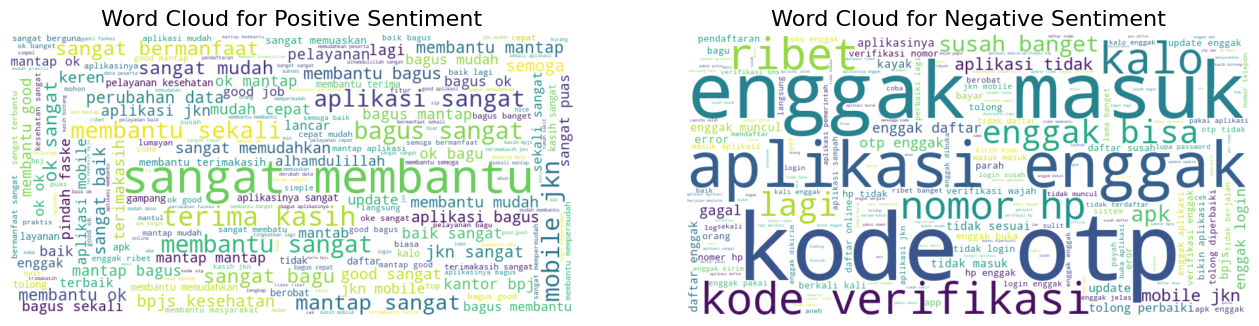

In [19]:
# Generate word cloud for positive sentiment
positive_text = " ".join(df_cleaned[df_cleaned["Sentimen"] == "positif"]["text_akhir"])
positive_wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate(positive_text)

# Generate word cloud for negative sentiment
negative_text = " ".join(df_cleaned[df_cleaned["Sentimen"] == "negatif"]["text_akhir"])
negative_wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate(negative_text)

# Plot the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Positive Sentiment", fontsize=16)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Negative Sentiment", fontsize=16)
plt.axis("off")

plt.show()

Insights:
- terdapat hal menarik setelah dilakukan visualisasi wordcloud, mobile jkn mendapatkan sentimen positif yang mengesankan, pengguna merasa bahwa aplikasi mobile jkn banyak membantu masyarakat. namun, dilain sisi, terdapat 2 permasalahan utama yang bisa digunakan sebagai bahan untuk perbaikan yaitu kdoe otp yang tidak masuk dan aplikasi yang menyulitkan pengguna (bisa dari sisi UI atau UX). kedua permasalahan tersebut bisa diperbaiki oleh pihak pengembang aplikasi sehingga mampu memberikan pengalaman pengguna yang lebih baik

# Feature Encoding

In [20]:
df_cleaned.replace(
    {"Sentimen": {"negatif": 0, "netral": 1, "positif": 2}}, inplace=True
)
df_cleaned.head()

Review  ...  Sentimen
Tanggal                                               ...          
2025-04-18 17:13:39  susah daftar, masih di persulit  ...         0
2025-04-18 17:12:59   alplikasi ora niat rued doboll  ...         0
2025-04-18 17:00:37                  sangat membantu  ...         2
2025-04-18 16:35:50                             good  ...         2
2025-04-18 16:33:35    sangat bermanfaat terimakasih  ...         2

[5 rows x 10 columns]

In [21]:
df_cleaned.reset_index(inplace=True)

# Feature Extraction

In [22]:
X = df_cleaned["text_akhir"]
y = df_cleaned["Sentimen"]

In [23]:
y

0         0
1         0
2         2
3         2
4         2
         ..
199992    0
199993    2
199994    0
199995    2
199996    0
Name: Sentimen, Length: 199997, dtype: int64

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=200)

X_vect = tfidf_vectorizer.fit_transform(X)
features_df = pd.DataFrame(
    X_vect.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# Menampilkan hasil ekstraksi fitur
features_df

akses  aktif  akun  alamat  ...  versi  via   wa  wajah
0         0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0
1         0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0
2         0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0
3         0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0
4         0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0
...       ...    ...   ...     ...  ...    ...  ...  ...    ...
199992    0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0
199993    0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0
199994    0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0
199995    0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0
199996    0.0    0.0   0.0     0.0  ...    0.0  0.0  0.0    0.0

[199997 rows x 200 columns]

# Experiment 1: 80:20 split size

## Split data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df, y, test_size=0.2, random_state=42, stratify=y
)

## Modeling

In [26]:
# Models dictionary
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "Linear-SVM": LinearSVC(random_state=42),
    "LogisticReg": LogisticRegression(random_state=42),
}

===================================== MultinomialNB Classifier =====================================
Training
Train Accuracy: 0.896716813440252
Train Precision: 0.867858840547982
Train Recall: 0.896716813440252
Train F1-Score: 0.8811016231561641
Confusion Matrix:


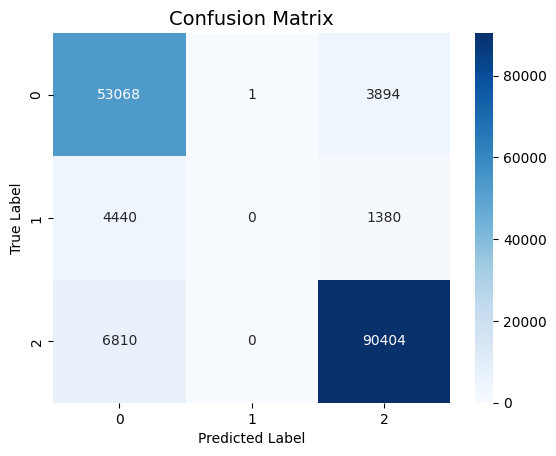


Testing
Test Accuracy: 0.898175
Test Precision: 0.8690442254477732
Test Recall: 0.898175
Test F1-Score: 0.8824917697874902
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     14241
           1       0.00      0.00      0.00      1455
           2       0.95      0.93      0.94     24304

    accuracy                           0.90     40000
   macro avg       0.59      0.62      0.61     40000
weighted avg       0.87      0.90      0.88     40000

Confusion Matrix:


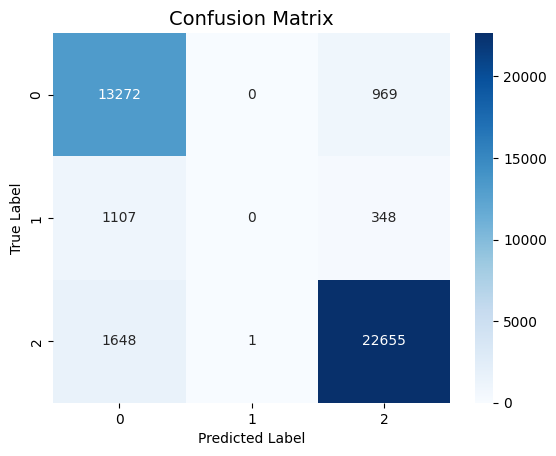

====================================== BernoulliNB Classifier ======================================
Training
Train Accuracy: 0.8705663231185585
Train Precision: 0.8534352616267338
Train Recall: 0.8705663231185585
Train F1-Score: 0.8608361164708999
Confusion Matrix:


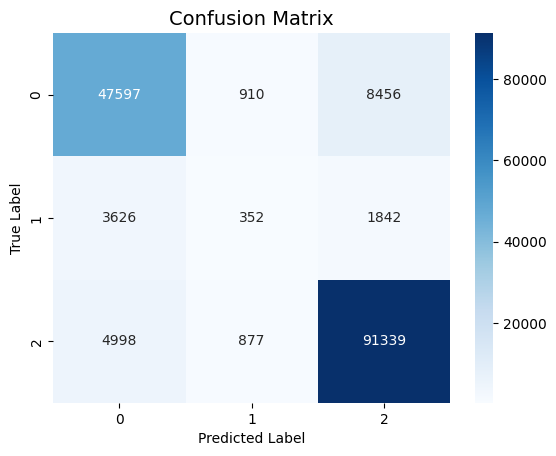


Testing
Test Accuracy: 0.873325
Test Precision: 0.8565882209640243
Test Recall: 0.873325
Test F1-Score: 0.8637565543359051
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     14241
           1       0.18      0.07      0.10      1455
           2       0.90      0.94      0.92     24304

    accuracy                           0.87     40000
   macro avg       0.64      0.62      0.62     40000
weighted avg       0.86      0.87      0.86     40000

Confusion Matrix:


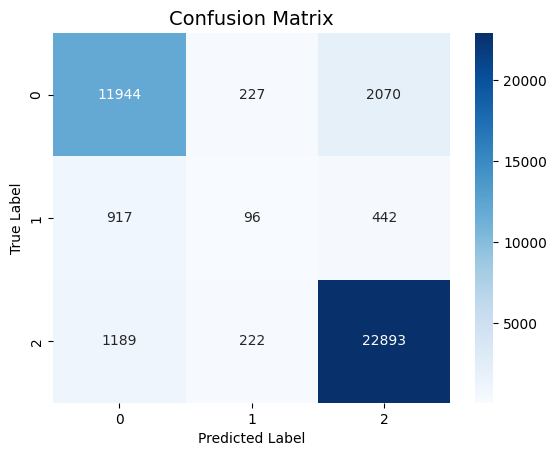

===================================== ComplementNB Classifier ======================================
Training
Train Accuracy: 0.8463283686569123
Train Precision: 0.8464106068003485
Train Recall: 0.8463283686569123
Train F1-Score: 0.8352626198561063
Confusion Matrix:


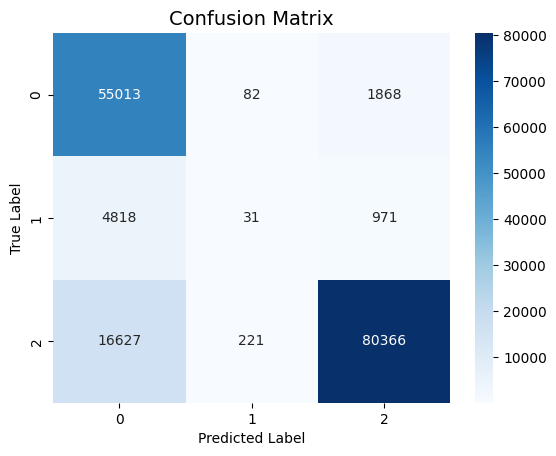


Testing
Test Accuracy: 0.846775
Test Precision: 0.8464147649491887
Test Recall: 0.846775
Test F1-Score: 0.8356205239806359
Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.97      0.82     14241
           1       0.08      0.00      0.01      1455
           2       0.97      0.83      0.89     24304

    accuracy                           0.85     40000
   macro avg       0.59      0.60      0.57     40000
weighted avg       0.85      0.85      0.84     40000

Confusion Matrix:


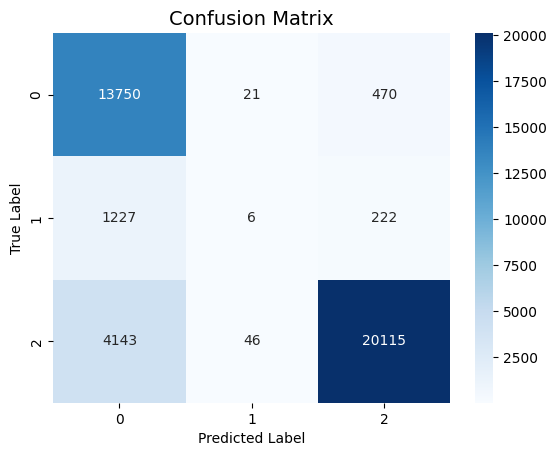

====================================== Linear-SVM Classifier =======================================
Training
Train Accuracy: 0.8994293643005806
Train Precision: 0.8685795239168242
Train Recall: 0.8994293643005806
Train F1-Score: 0.8833624213659228
Confusion Matrix:


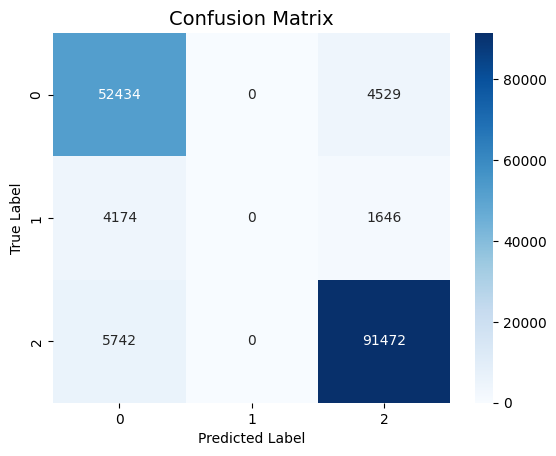


Testing
Test Accuracy: 0.90035
Test Precision: 0.8693689233719096
Test Recall: 0.90035
Test F1-Score: 0.8842389952516388
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     14241
           1       0.00      0.00      0.00      1455
           2       0.94      0.94      0.94     24304

    accuracy                           0.90     40000
   macro avg       0.59      0.62      0.61     40000
weighted avg       0.87      0.90      0.88     40000

Confusion Matrix:


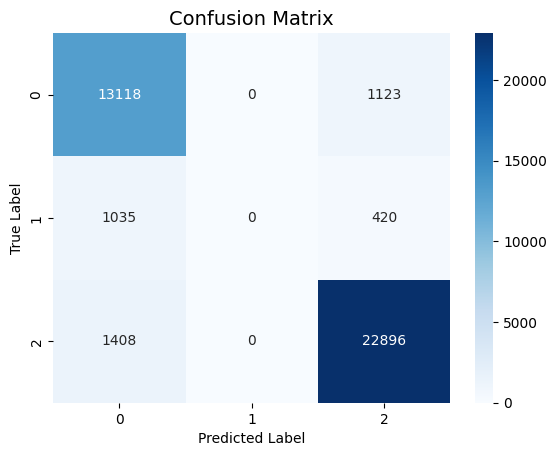

====================================== LogisticReg Classifier ======================================
Training
Train Accuracy: 0.900329381175897
Train Precision: 0.8768024898539314
Train Recall: 0.900329381175897
Train F1-Score: 0.8842937823097908
Confusion Matrix:


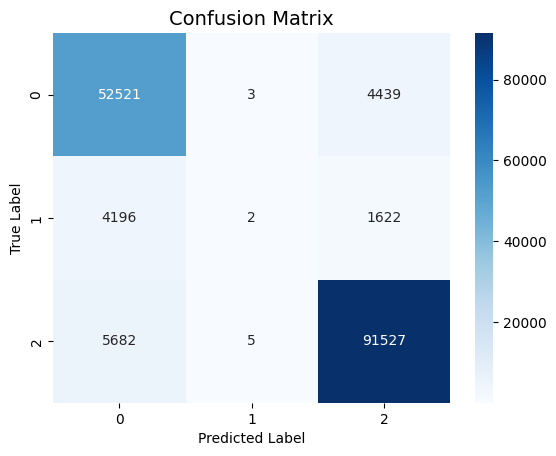


Testing
Test Accuracy: 0.901425
Test Precision: 0.894682632039078
Test Recall: 0.901425
Test F1-Score: 0.8853781819069513
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     14241
           1       0.67      0.00      0.00      1455
           2       0.94      0.94      0.94     24304

    accuracy                           0.90     40000
   macro avg       0.82      0.62      0.61     40000
weighted avg       0.89      0.90      0.89     40000

Confusion Matrix:


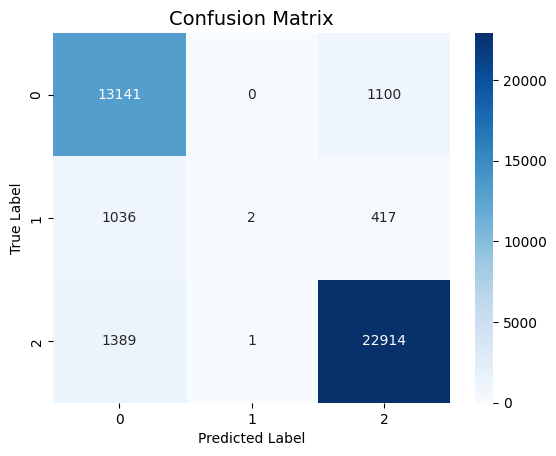

Model  Train Accuracy  ...   Test F1  Training Time (seconds)
0  MultinomialNB        0.896717  ...  0.882492                 0.518864
1    BernoulliNB        0.870566  ...  0.863757                 1.559205
2   ComplementNB        0.846328  ...  0.835621                 0.355284
3     Linear-SVM        0.899429  ...  0.884239                 4.198096
4    LogisticReg        0.900329  ...  0.885378                 7.657863

[5 rows x 10 columns]

In [27]:
result = train_and_evaluate_models(X_train, X_test, y_train, y_test, models)

result

In [28]:
result.to_csv(REPORT_PATH / "results_80_20.csv", index=False)

# Experiment 2: 90:10 split size

## Split data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df, y, test_size=0.1, random_state=42, stratify=y
)

## Modeling

===================================== MultinomialNB Classifier =====================================
Training
Train Accuracy: 0.8968371695083807
Train Precision: 0.8679722364788022
Train Recall: 0.8968371695083807
Train F1-Score: 0.881219791610101
Confusion Matrix:


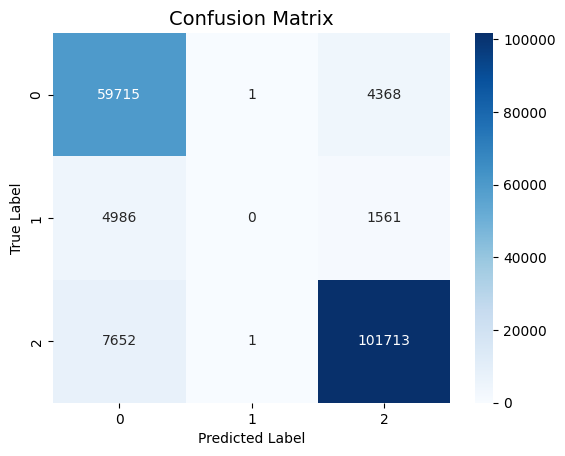


Testing
Test Accuracy: 0.8978
Test Precision: 0.8687996615435033
Test Recall: 0.8978
Test F1-Score: 0.8821408796016089
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      7120
           1       0.00      0.00      0.00       728
           2       0.95      0.93      0.94     12152

    accuracy                           0.90     20000
   macro avg       0.59      0.62      0.60     20000
weighted avg       0.87      0.90      0.88     20000

Confusion Matrix:


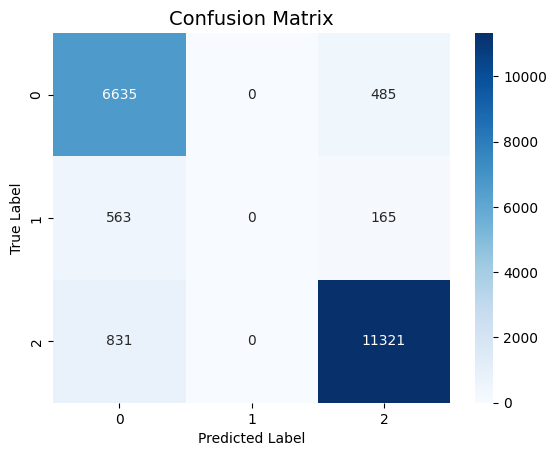

====================================== BernoulliNB Classifier ======================================
Training
Train Accuracy: 0.8709589604271182
Train Precision: 0.8540736374971418
Train Recall: 0.8709589604271182
Train F1-Score: 0.8613648843946483
Confusion Matrix:


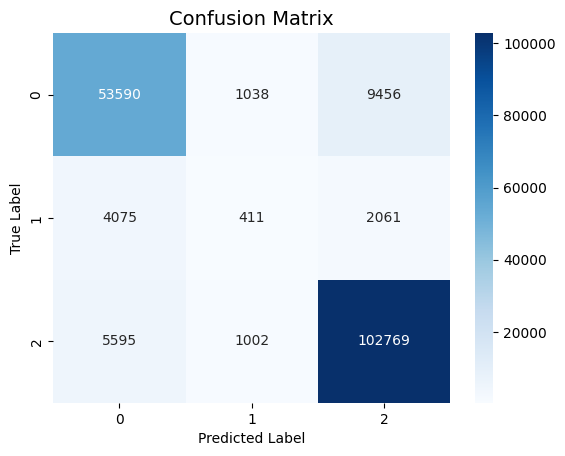


Testing
Test Accuracy: 0.87325
Test Precision: 0.8551299727436604
Test Recall: 0.87325
Test F1-Score: 0.8629954826240311
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      7120
           1       0.15      0.05      0.08       728
           2       0.90      0.94      0.92     12152

    accuracy                           0.87     20000
   macro avg       0.63      0.61      0.61     20000
weighted avg       0.86      0.87      0.86     20000

Confusion Matrix:


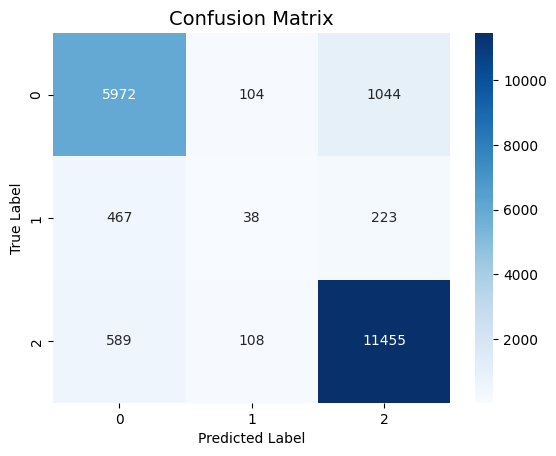

===================================== ComplementNB Classifier ======================================
Training
Train Accuracy: 0.8462752156980394
Train Precision: 0.8463885065952712
Train Recall: 0.8462752156980394
Train F1-Score: 0.8351885248603935
Confusion Matrix:


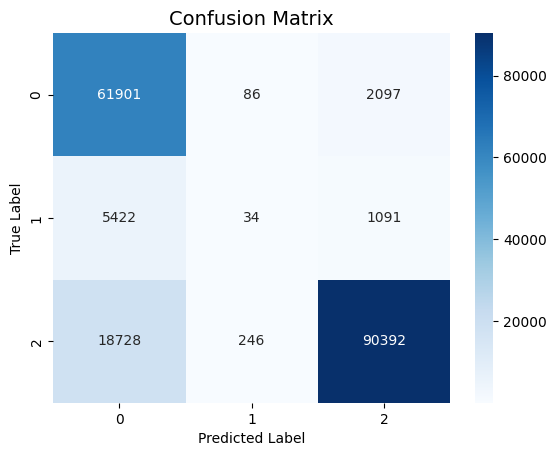


Testing
Test Accuracy: 0.8475
Test Precision: 0.8478803125549567
Test Recall: 0.8475
Test F1-Score: 0.836383157276408
Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      7120
           1       0.11      0.01      0.01       728
           2       0.97      0.83      0.89     12152

    accuracy                           0.85     20000
   macro avg       0.60      0.60      0.58     20000
weighted avg       0.85      0.85      0.84     20000

Confusion Matrix:


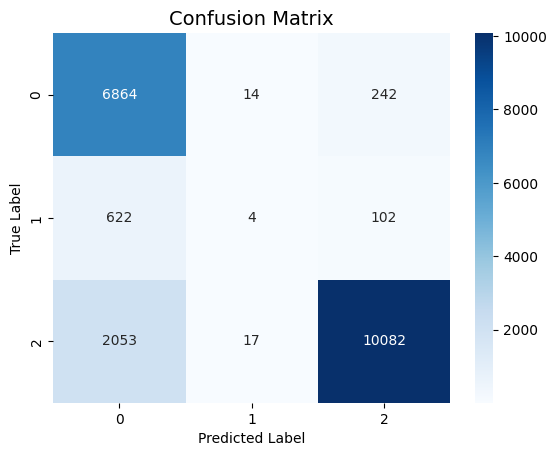

====================================== Linear-SVM Classifier =======================================
Training
Train Accuracy: 0.8995983266387774
Train Precision: 0.8687467807751832
Train Recall: 0.8995983266387774
Train F1-Score: 0.8835294980495327
Confusion Matrix:


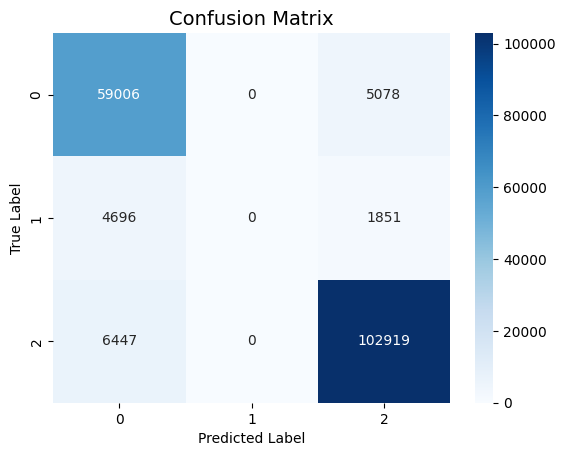


Testing
Test Accuracy: 0.89915
Test Precision: 0.8681695907883284
Test Recall: 0.89915
Test F1-Score: 0.8830521518924086
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      7120
           1       0.00      0.00      0.00       728
           2       0.94      0.94      0.94     12152

    accuracy                           0.90     20000
   macro avg       0.59      0.62      0.61     20000
weighted avg       0.87      0.90      0.88     20000

Confusion Matrix:


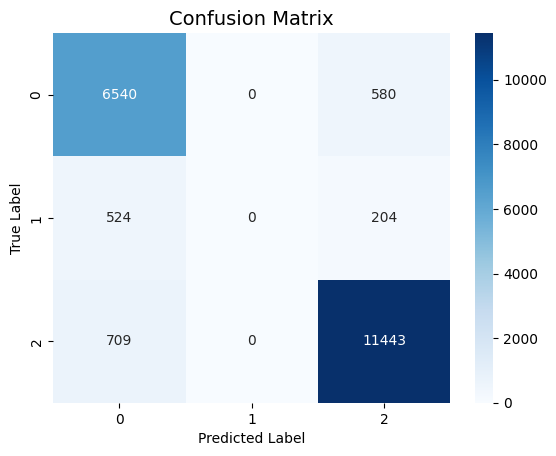

====================================== LogisticReg Classifier ======================================
Training
Train Accuracy: 0.9004761190464285
Train Precision: 0.8780493896723104
Train Recall: 0.9004761190464285
Train F1-Score: 0.8844423143761602
Confusion Matrix:


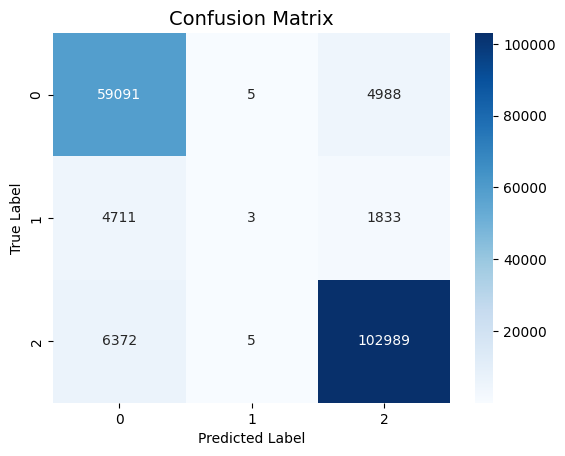


Testing
Test Accuracy: 0.8998
Test Precision: 0.9052171618929198
Test Recall: 0.8998
Test F1-Score: 0.8837689154901939
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      7120
           1       1.00      0.00      0.00       728
           2       0.94      0.94      0.94     12152

    accuracy                           0.90     20000
   macro avg       0.93      0.62      0.61     20000
weighted avg       0.91      0.90      0.88     20000

Confusion Matrix:


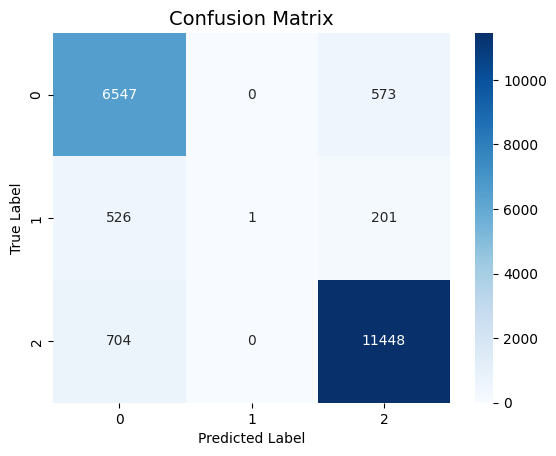

Model  Train Accuracy  ...   Test F1  Training Time (seconds)
0  MultinomialNB        0.896837  ...  0.882141                 0.234828
1    BernoulliNB        0.870959  ...  0.862995                 2.342315
2   ComplementNB        0.846275  ...  0.836383                 0.463413
3     Linear-SVM        0.899598  ...  0.883052                 6.508058
4    LogisticReg        0.900476  ...  0.883769                29.686669

[5 rows x 10 columns]

In [30]:
result_2 = train_and_evaluate_models(X_train, X_test, y_train, y_test, models)

result_2

In [31]:
result_2.to_csv(REPORT_PATH / "results_90_10.csv", index=False)

# Model Selection

Models Comparation:
- ketiga model yaitu Naive Bayes, SVM, dan Logistic Regression menghasilkan performa yang bagus. ketiga model tersebut berhasil melakukan generalisasi pada data baru (data testing) bisa dilihat akurasi pada data training dan data testing seimbang tidak ada selisih yang besar.
- pada kedua percobaan model Logistic Regression menghasilan performa model yang paling bagus dibandingkan dengan model-model lainnya. sehingga model logistic regression dipilih sebagai final_model

In [34]:
save_model(tfidf_vectorizer, file_path=MODELS_PATH / "tfidf_vectorizer.pkl")

In [35]:
save_model(models["LogisticReg"], file_path=MODELS_PATH / "final_model.pkl")

# Simple Deployment

In [39]:
model = joblib.load(open(MODELS_PATH / "final_model.pkl", "rb"))
tfidf_vectorizer = joblib.load(open(MODELS_PATH / "tfidf_vectorizer.pkl", "rb"))

# Sample text for prediction from user input
sample_text = input("Masukkan teks ulasan: ")
print("Your input:", sample_text)

""" 
contoh :
Aplikasi ini sangat membantu, tetapi 
sering mengalami masalah teknis. Saya 
berharap ada pembaruan untuk memperbaiki bug ini. T
erima kasih!"
"""

# Membersihkan teks dan menyimpannya di kolom 'text_clean'
sample_text_clean = cleaningText(sample_text)
sample_text_token = tokenizingText(sample_text_clean)
sample_text_slang = replace_slang_word(sample_text_token)
sample_text_stop = filteringText(sample_text_slang)
sample_text_final = toSentence(sample_text_stop)
sample_text_final

# Transform the cleaned text into TF-IDF features
sample_text_vectorized = tfidf_vectorizer.transform([sample_text_final])

# Predict the sentiment using the trained model
predicted_sentiment = model.predict(sample_text_vectorized)
predicted_sentiment_proba = model.predict_proba(sample_text_vectorized)

# Map the predicted sentiment back to its original label
sentiment_mapping = {0: "negatif", 1: "netral", 2: "positif"}
predicted_sentiment = [sentiment_mapping[i] for i in predicted_sentiment]

# print the predicted sentiment and its probability
print(f"Predicted Sentiment: {predicted_sentiment[0]}")
print(f"Predicted Sentiment Probability: {predicted_sentiment_proba[0]}")

Your input: aplikasinya bagus banget deh
Predicted Sentiment: positif
Predicted Sentiment Probability: [0.13635657 0.03114947 0.83249396]
